In [54]:
#모든 participant 파일 하나로 합치기

import pandas as pd
import os

all_data = []

# 1️⃣ control 데이터
control_path = "C:/Users/asia/Downloads/depresjon/data/control"

for file in os.listdir(control_path):
    df = pd.read_csv(os.path.join(control_path, file))
    
    participant_id = file.replace(".csv", "")
    df["participant_id"] = participant_id
    df["group"] = 0   # 정상
    
    all_data.append(df)

# 2️⃣ condition 데이터
condition_path = "C:/Users/asia/Downloads/depresjon/data/condition"

for file in os.listdir(condition_path):
    df = pd.read_csv(os.path.join(condition_path, file))
    
    participant_id = file.replace(".csv", "")
    df["participant_id"] = participant_id
    df["group"] = 1   # 우울
    
    all_data.append(df)

# 3️⃣ 하나로 합치기
df_all = pd.concat(all_data, ignore_index=True)

print(df_all.head())


             timestamp        date  activity participant_id  group
0  2003-03-18 15:00:00  2003-03-18        60      control_1      0
1  2003-03-18 15:01:00  2003-03-18         0      control_1      0
2  2003-03-18 15:02:00  2003-03-18       264      control_1      0
3  2003-03-18 15:03:00  2003-03-18       662      control_1      0
4  2003-03-18 15:04:00  2003-03-18       293      control_1      0


In [112]:
# scores.csv 병합
import pandas as pd

# 1. scores 데이터 로드
scores = pd.read_csv("C:/Users/asia/Downloads/depresjon/data/scores.csv")

# 2. df_all 초기화 (기존의 _x, _y 등 지저분한 컬럼 제거)
# 활동량 원본 데이터 컬럼만 추출합니다.
base_cols = ['timestamp', 'date', 'activity', 'participant_id', 'group']
df_clean = df_all[base_cols].copy()

# 3. ID 매칭 확인 및 공백 제거 (혹시 모를 에러 방지)
df_clean['participant_id'] = df_clean['participant_id'].astype(str).str.strip()
scores['number'] = scores['number'].astype(str).str.strip()

# 4. 재병합 (Left Join)
# scores의 모든 정보를 participant_id 기준으로 합칩니다.
all_data = pd.merge(df_clean, scores, left_on='participant_id', right_on='number', how='left')

# 5. 중복된 ID 컬럼 삭제 및 결과 확인
if 'number' in all_data.columns:
    all_data.drop(columns=['number'], inplace=True)

# 6. 최종 결측치 확인
print("--- 병합 후 결측치 상태 ---")
print(all_data.isnull().sum())
all_data.info()

--- 병합 후 결측치 상태 ---
timestamp               0
date                    0
activity                0
participant_id          0
group                   0
days                    0
gender                  0
age                     0
afftype           1019990
melanch           1081782
inpatient         1019990
edu                 73868
marriage          1019990
work              1019990
madrs1            1019990
madrs2            1019990
dtype: int64
<class 'pandas.DataFrame'>
RangeIndex: 1571706 entries, 0 to 1571705
Data columns (total 16 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   timestamp       1571706 non-null  str    
 1   date            1571706 non-null  str    
 2   activity        1571706 non-null  int64  
 3   participant_id  1571706 non-null  str    
 4   group           1571706 non-null  int64  
 5   days            1571706 non-null  int64  
 6   gender          1571706 non-null  int64  
 7   age             15717

# 전처리-데이터 불균형

In [123]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import ADASYN, SMOTE
from collections import Counter

# 1. 데이터 평탄화 및 데이터프레임 생성 (기존 로직 유지)
if isinstance(all_data, list):
 all_data = pd.DataFrame(all_data)

def flatten_cell(x):
 if isinstance(x, (list, np.ndarray, pd.Series)):
  return x[0] if len(x) > 0 else np.nan
 return x

for col in all_data.columns:
 if all_data[col].apply(lambda x: isinstance(x, (list, np.ndarray, pd.Series))).any():
  if col == 'activity':
   all_data[col] = all_data[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray, pd.Series)) else x)
  else:
   all_data[col] = all_data[col].apply(flatten_cell)

# 2. 피처 추출 및 타겟 정의
features = all_data.groupby('participant_id')['activity'].agg(['mean', 'std', 'skew', 'kurt']).reset_index()
labels_map = all_data.groupby('participant_id')['group'].first()
y = features['participant_id'].map(labels_map).values
X_raw = features.drop(columns=['participant_id']).fillna(0)
y = np.nan_to_num(y).astype(int)

# 3. ADASYN 적용 전 분포 확인
dist_before = Counter(y)
print("-" * 45)
print(f"[1] 불균형 해소 전 클래스 분포")
print(f" - 대조군 (0): {dist_before.get(0, 0)}명")
print(f" - 우울증군 (1): {dist_before.get(1, 0)}명")
print("-" * 45)

# 4. 데이터 불균형 해소 (강제 1:1 매칭)
# ADASYN이 데이터를 충분히 생성하지 못할 경우를 대비해 SMOTE를 대안으로 사용하거나
# ADASYN의 이웃 수를 최소화(1)하여 생성 범위를 넓힙니다.
try:
 # n_neighbors를 1.8로 낮추면 아주 좁은 데이터 사이에서도 증강 데이터를 만들어내어 32명을 채울 확률이 높아집니다.

 sampler = ADASYN(random_state=42, n_neighbors=5, sampling_strategy='minority')
 X_resampled, y_resampled = sampler.fit_resample(X_raw, y)
except:
 # 만약 ADASYN으로도 부족하다면 선형 보간법인 SMOTE를 사용하여 정확히 32:32를 맞춥니다.
 sampler = SMOTE(random_state=42, k_neighbors=7)
 X_resampled, y_resampled = sampler.fit_resample(X_raw, y)

# 5. 결과 확인
dist_after = Counter(y_resampled)
print(f"[2] 불균형 해소 후 클래스 분포 (1:1 목표)")
print(f" - 대조군 (0): {dist_after.get(0, 0)}명")
print(f" - 우울증군 (1): {dist_after.get(1, 0)}명")
print("-" * 45)
print(f"증강된 샘플 수: {len(y_resampled) - len(y)}개")
print("-" * 45)

---------------------------------------------
[1] 불균형 해소 전 클래스 분포
 - 대조군 (0): 32명
 - 우울증군 (1): 23명
---------------------------------------------
[2] 불균형 해소 후 클래스 분포 (1:1 목표)
 - 대조군 (0): 32명
 - 우울증군 (1): 34명
---------------------------------------------
증강된 샘플 수: 11개
---------------------------------------------


In [57]:
# # smote 기법 적용
# import pandas as pd
# import numpy as np
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# # 1. 데이터 평탄화 및 데이터프레임 생성
# if isinstance(all_data, list):
#  all_data = pd.DataFrame(all_data)

# def flatten_cell(x):
#  if isinstance(x, (list, np.ndarray, pd.Series)):
#   return x[0] if len(x) > 0 else np.nan
#  return x

# for col in all_data.columns:
#  if all_data[col].apply(lambda x: isinstance(x, (list, np.ndarray, pd.Series))).any():
#   if col == 'activity':
#    all_data[col] = all_data[col].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray, pd.Series)) else x)
#   else:
#    all_data[col] = all_data[col].apply(flatten_cell)

# # 2. 피처 추출 및 타겟 정의
# features = all_data.groupby('participant_id')['activity'].agg(['mean', 'std', 'skew', 'kurt']).reset_index()
# labels_map = all_data.groupby('participant_id')['group'].first()
# y = features['participant_id'].map(labels_map).values
# X_raw = features.drop(columns=['participant_id']).fillna(0)
# y = np.nan_to_num(y).astype(int)

# # 3. SMOTE 적용 전 분포 확인
# dist_before = Counter(y)
# print("-" * 45)
# print(f"[1] SMOTE 적용 전 클래스 분포")
# print(f" - 대조군 (0): {dist_before.get(0, 0)}명")
# print(f" - 우울증군 (1): {dist_before.get(1, 0)}명")
# print("-" * 45)

# # 4. SMOTE 기법으로 불균형 해소 (1:1 매칭)
# # k_neighbors는 주변 이웃 수를 의미하며, 데이터가 적을 때는 1~3 정도가 적당합니다.
# sampler = SMOTE(random_state=42, k_neighbors=3, sampling_strategy='minority')
# X_resampled, y_resampled = sampler.fit_resample(X_raw, y)

# # 5. 결과 확인 (문자 출력)
# dist_after = Counter(y_resampled)
# print(f"[2] SMOTE 적용 후 클래스 분포 (1:1 완성)")
# print(f" - 대조군 (0): {dist_after.get(0, 0)}명")
# print(f" - 우울증군 (1): {dist_after.get(1, 0)}명")
# print("-" * 45)
# print(f"증강된 샘플 수: {len(y_resampled) - len(y)}개 (23 -> 32)")
# print("-" * 45)

# 정규화

In [58]:
from sklearn.preprocessing import StandardScaler

# 1. Z-score 정규화 도구 선언
scaler = StandardScaler()

# 2. 정규화 전 데이터 상태 확인 (샘플로 첫 번째 피처의 통계량 계산)
# X_resampled는 데이터프레임 형태이므로 .mean(), .std() 사용 가능
print("-" * 45)
print(f"[3] Z-score 정규화 적용 전 통계 (첫 번째 피처 기준)")
print(f" - 평균 (Mean): {np.mean(X_resampled.iloc[:, 0]):.4f}")
print(f" - 표준편차 (Std): {np.std(X_resampled.iloc[:, 0]):.4f}")
print("-" * 45)

# 3. [논문 단계 2] Z-score 정규화 수행
# 불균형 해소가 된 X_resampled 데이터를 표준화합니다.
X_final = scaler.fit_transform(X_resampled)

# 4. 정규화 후 데이터 상태 확인
# 정규화 후에는 모든 피처의 평균이 0, 표준편차가 1에 가까워집니다.
print(f"[4] Z-score 정규화 적용 후 통계 (첫 번째 피처 기준)")
print(f" - 평균 (Mean): {np.mean(X_final[:, 0]):.4f} (→ 0에 수렴)")
print(f" - 표준편차 (Std): {np.std(X_final[:, 0]):.4f} (→ 1에 수렴)")
print("-" * 45)
print("결과: 논문 프로세스에 따라 ADASYN/SMOTE 후 Z-score 정규화가 완료되었습니다.")
print(f"최종 학습 데이터셋 형태: {X_final.shape}")
print("-" * 45)

---------------------------------------------
[3] Z-score 정규화 적용 전 통계 (첫 번째 피처 기준)
 - 평균 (Mean): 192.3015
 - 표준편차 (Std): 77.0337
---------------------------------------------
[4] Z-score 정규화 적용 후 통계 (첫 번째 피처 기준)
 - 평균 (Mean): -0.0000 (→ 0에 수렴)
 - 표준편차 (Std): 1.0000 (→ 1에 수렴)
---------------------------------------------
결과: 논문 프로세스에 따라 ADASYN/SMOTE 후 Z-score 정규화가 완료되었습니다.
최종 학습 데이터셋 형태: (63, 4)
---------------------------------------------


# 피처 엔지니어링

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler

# 1. 데이터 전처리 함수 (나이 문자열 해결)
def clean_demographics(df):
    # 나이(age) 컬럼이 있을 경우 수치화 ('35-39' -> 35)
    if 'age' in df.columns:
        df['age'] = df['age'].apply(lambda x: int(str(x).split('-')[0]) if '-' in str(x) else pd.to_numeric(x, errors='coerce'))
        df['age'] = df['age'].fillna(df['age'].mean()) # 결측치는 평균으로 대체
    
    # 성별(gender) 컬럼 수치화 (남/여 문자열일 경우 대비)
    if 'gender' in df.columns:
        if df['gender'].dtype == 'object':
            df['gender'] = pd.factorize(df['gender'])[0]
    return df

# 데이터 정제 적용
all_data = clean_demographics(all_data)

# 2. [논문 기준] 5개 범주 다차원 특징 추출 함수
def extract_multidimensional_features(group):
    act = group['activity'].values
    if len(act) < 2: return None
    
    # [범주 1] 시간 도메인 (Time Domain)
    mean_act = np.mean(act)
    std_act = np.std(act)
    skew_act = skew(act)
    kurt_act = kurtosis(act)
    # 자기상관 (Autocorrelation) - Lag 1
    autocorr = np.corrcoef(act[:-1], act[1:])[0, 1] if len(act) > 1 else 0
    
    # [범주 2] 주파수 도메인 (Frequency Domain)
    # PSD (Power Spectral Density) 평균
    freqs, psd = welch(act, nperseg=min(len(act), 256))
    psd_mean = np.mean(psd)
    
    # [범주 3] 일주기 리듬 (Circadian Rhythm / Sleep)
    # Zero activity ratio: 활동량이 0인 비율 (수면/휴식 분석)
    zero_ratio = np.sum(act == 0) / len(act)
    
    # [범주 4] 전환 특징 (Transition Features)
    # 변동 계수(CV): 활동의 급격한 변화나 전환 패턴 측정
    cv_val = std_act / mean_act if mean_act != 0 else 0
    
    # [범주 5] 인구통계 (Demographics)
    age = group['age'].iloc[0] if 'age' in group.columns else 0
    gender = group['gender'].iloc[0] if 'gender' in group.columns else 0
    
    return pd.Series({
        'mean': mean_act, 'std': std_act, 'skew': skew_act, 'kurt': kurt_act,
        'autocorr': autocorr, 'psd_mean': psd_mean, 
        'zero_ratio': zero_ratio, 'cv': cv_val,
        'age': age, 'gender': gender
    })

# 3. 특징 추출 및 정규화
X_raw = all_data.groupby('participant_id').apply(extract_multidimensional_features).reset_index()
X_raw = X_raw.drop(columns=['participant_id']).fillna(0)

# Z-score 정규화
scaler = StandardScaler()
X_final = scaler.fit_transform(X_raw)
X_norm_df = pd.DataFrame(X_final, columns=X_raw.columns)

# 4. [최종 결과 보고서 출력]
print("\n" + "-" * 50)
print("[Step: 다차원 특징 추출 (5개 범주) 분석 보고]")
print("-" * 50)

print("\n=== [Feature Extraction 결과 보고서] ===")
# 요청하신 형식에 맞춰 X_raw의 평균 수치 출력
feature_summary = X_raw.mean()
report_items = {
    'mean': 'Mean (평균)',
    'std': 'Std Dev (표준편차)',
    'skew': 'Skewness (왜도)',
    'kurt': 'Kurtosis (첨도)',
    'autocorr': 'Autocorrelation (자기상관)',
    'psd_mean': 'PSD Mean (추정치)',
    'zero_ratio': 'Zero Ratio (일주기/수면)',
    'cv': 'Transition (전환 특징)'
}

for key, display_name in report_items.items():
    if key in feature_summary:
        print(f"{display_name:<30} {feature_summary[key]:e}")

print("========================================")
print(f"최종 특징 벡터 차원: {len(X_norm_df.columns)}")
print(f"추출된 특징 리스트: {list(X_norm_df.columns)}")
print("-" * 50)


--------------------------------------------------
[Step: 다차원 특징 추출 (5개 범주) 분석 보고]
--------------------------------------------------

=== [Feature Extraction 결과 보고서] ===
Mean (평균)                      1.898626e+02
Std Dev (표준편차)                 3.405531e+02
Skewness (왜도)                  3.179017e+00
Kurtosis (첨도)                  1.730031e+01
Autocorrelation (자기상관)         7.721273e-01
PSD Mean (추정치)                 1.717867e+05
Zero Ratio (일주기/수면)            4.041095e-01
Transition (전환 특징)             1.937257e+00
최종 특징 벡터 차원: 10
추출된 특징 리스트: ['mean', 'std', 'skew', 'kurt', 'autocorr', 'psd_mean', 'zero_ratio', 'cv', 'age', 'gender']
--------------------------------------------------


# 모델 학습

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import ADASYN
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# [준비 단계] 데이터 로드 및 타겟 설정
# ---------------------------------------------------------
target_info = all_data.groupby('participant_id').agg({
 'group': 'first',
 'madrs1': 'first'
}).reset_index(drop=True)

# ---------------------------------------------------------
# [연구 프로세스] 논문 순서에 따른 파이프라인 함수
# ---------------------------------------------------------
def run_technical_pipeline(X_data, y_data, task_name):
 
 # 1. 불균형 해소 (ADASYN)
 # 특정 클래스 편향 문제를 해결하기 위해 가장 먼저 증강 수행
 le = LabelEncoder()
 y_encoded = le.fit_transform(y_data)
 
 min_class_count = pd.Series(y_encoded).value_counts().min()
 if min_class_count > 1:
  n_neigh = min(7, min_class_count - 1)
  try:
   ada = ADASYN(random_state=42, n_neighbors=n_neigh)
   X_res, y_res = ada.fit_resample(X_data, y_encoded)
  except:
   X_res, y_res = X_data, y_encoded
 else:
  X_res, y_res = X_data, y_encoded

 # 2. 데이터 정규화 (Z-score Normalization)
 # 데이터의 척도를 맞추기 위해 StandardScaler를 사용하여 표준화 수행
 scaler = StandardScaler()
 X_scaled = scaler.fit_transform(X_res)

 # 3. 다차원 특징 추출 (Feature Engineering)
 # 정규화된 데이터로부터 시간/주파수/수면/전이 특징 등이 포함된 상태(X_raw 기반) 활용
 # (이미 X_raw가 추출된 상태라면 X_scaled가 그 역할을 수행하게 됩니다)
 X_final = X_scaled 

 # 4. 모델 학습 및 분류 (Algorithm Implementation)
 # 8:2 분할 후 5종의 알고리즘으로 학습
 try:
  X_train, X_test, y_train, y_test = train_test_split(
   X_final, y_res, test_size=0.2, random_state=42, stratify=y_res
  )
 except:
  X_train, X_test, y_train, y_test = train_test_split(
   X_final, y_res, test_size=0.2, random_state=42
  )

 models = {
  "LR": LogisticRegression(max_iter=2000),
  "SVM": SVC(probability=True, random_state=42),
  "RF": RandomForestClassifier(random_state=42),
  "XGB": XGBClassifier(random_state=42),
  "NN": MLPClassifier(max_iter=1000, random_state=42)
 }

 results = []
 avg_method = 'binary' if len(np.unique(y_res)) == 2 else 'weighted'

 for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  
  # 5. 모델 평가 (Performance Evaluation)
  results.append({
   "Model": name,
   "Accuracy": round(accuracy_score(y_test, y_pred), 3),
   "Precision": round(precision_score(y_test, y_pred, average=avg_method, zero_division=0), 3),
   "Recall": round(recall_score(y_test, y_pred, average=avg_method), 3),
   "F1-Score": round(f1_score(y_test, y_pred, average=avg_method), 3),
   "MCC": round(matthews_corrcoef(y_test, y_pred), 3)
  })

 print(f"\n--- [{task_name} 성능 결과] ---")
 print(pd.DataFrame(results).to_string(index=False))

# ---------------------------------------------------------
# 최종 실행
# ---------------------------------------------------------
# Task 1: 이진 분류 (우울증 유무 Detection)
run_technical_pipeline(X_raw, target_info['group'], "이진 분류 (Detection)")

# Task 2: 다중 분류 (심각도 Severity)
def assign_sev(m):
 if m <= 6: return 0  # Normal
 elif m <= 19: return 1 # Mild
 else: return 2     # Moderate

y_sev = target_info['madrs1'].apply(assign_sev)
run_technical_pipeline(X_raw, y_sev, "다중 분류 (Severity)")


--- [이진 분류 (Detection) 성능 결과] ---
Model  Accuracy  Precision  Recall  F1-Score   MCC
   LR     0.667      0.571     0.8     0.667 0.371
  SVM     0.667      0.667     0.4     0.500 0.293
   RF     0.667      0.667     0.4     0.500 0.293
  XGB     0.833      1.000     0.6     0.750 0.683
   NN     0.750      0.750     0.6     0.667 0.478

--- [다중 분류 (Severity) 성능 결과] ---
Model  Accuracy  Precision  Recall  F1-Score   MCC
   LR      0.80        0.8     0.8     0.800 0.600
  SVM      0.95        1.0     0.9     0.947 0.905
   RF      0.90        1.0     0.8     0.889 0.816
  XGB      0.85        1.0     0.7     0.824 0.734
   NN      0.90        1.0     0.8     0.889 0.816


smotr(1:1 비율 기법 적용)

In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE # ADASYN 대신 SMOTE 임포트
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# [준비 단계] 데이터 로드 및 타겟 설정
# ---------------------------------------------------------
target_info = all_data.groupby('participant_id').agg({
 'group': 'first',
 'madrs1': 'first'
}).reset_index(drop=True)

# ---------------------------------------------------------
# [연구 프로세스] 논문 순서에 따른 파이프라인 함수
# ---------------------------------------------------------
def run_technical_pipeline(X_data, y_data, task_name):
 
 # 1. 불균형 해소 (SMOTE - 1:1 비율)
 # 소수 클래스 데이터를 생성하여 모든 클래스의 비율을 동일하게 맞춤
 le = LabelEncoder()
 y_encoded = le.fit_transform(y_data)
 
 # 클래스별 샘플 수 확인
 class_counts = pd.Series(y_encoded).value_counts()
 min_class_count = class_counts.min()
 
 # SMOTE 적용 (샘플이 너무 적으면 에러가 발생할 수 있으므로 체크)
 if min_class_count > 1:
  n_neigh = min(5, min_class_count - 1)
  try:
   # sampling_strategy='auto'는 모든 클래스를 다수 클래스 개수와 동일하게 만듭니다 (1:1 비율)
   smote = SMOTE(random_state=42, k_neighbors=n_neigh, sampling_strategy='auto')
   X_res, y_res = smote.fit_resample(X_data, y_encoded)
  except Exception as e:
   print(f"SMOTE 적용 중 오류 발생: {e}")
   X_res, y_res = X_data, y_encoded
 else:
  X_res, y_res = X_data, y_encoded

 # 2. 데이터 정규화 (Z-score Normalization)
 scaler = StandardScaler()
 X_scaled = scaler.fit_transform(X_res)

 # 3. 다차원 특징 추출 (X_final 설정)
 X_final = X_scaled 

 # 4. 모델 학습 및 분류
 try:
  X_train, X_test, y_train, y_test = train_test_split(
   X_final, y_res, test_size=0.2, random_state=42, stratify=y_res
  )
 except:
  X_train, X_test, y_train, y_test = train_test_split(
   X_final, y_res, test_size=0.2, random_state=42
  )

 models = {
  "LR": LogisticRegression(max_iter=2000),
  "SVM": SVC(probability=True, random_state=42),
  "RF": RandomForestClassifier(random_state=42),
  "XGB": XGBClassifier(random_state=42),
  "NN": MLPClassifier(max_iter=1000, random_state=42)
 }

 results = []
 # 이진 분류인지 다중 분류인지에 따라 평균 계산 방식 결정
 avg_method = 'binary' if len(np.unique(y_res)) == 2 else 'weighted'

 for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  
  # 5. 모델 평가
  results.append({
   "Model": name,
   "Accuracy": round(accuracy_score(y_test, y_pred), 3),
   "Precision": round(precision_score(y_test, y_pred, average=avg_method, zero_division=0), 3),
   "Recall": round(recall_score(y_test, y_pred, average=avg_method), 3),
   "F1-Score": round(f1_score(y_test, y_pred, average=avg_method), 3),
   "MCC": round(matthews_corrcoef(y_test, y_pred), 3)
  })

 print(f"\n--- [{task_name} 성능 결과 (SMOTE 적용)] ---")
 print(pd.DataFrame(results).to_string(index=False))

# ---------------------------------------------------------
# 최종 실행
# ---------------------------------------------------------
# Task 1: 이진 분류 (우울증 유무 Detection)
run_technical_pipeline(X_raw, target_info['group'], "이진 분류 (Detection)")

# Task 2: 다중 분류 (심각도 Severity)
def assign_sev(m):
 if m <= 6: return 0  # Normal
 elif m <= 19: return 1 # Mild
 else: return 2     # Moderate

y_sev = target_info['madrs1'].apply(assign_sev)
run_technical_pipeline(X_raw, y_sev, "다중 분류 (Severity)")


--- [이진 분류 (Detection) 성능 결과 (SMOTE 적용)] ---
Model  Accuracy  Precision  Recall  F1-Score    MCC
   LR     0.615      0.600   0.500     0.545  0.220
  SVM     0.462      0.333   0.167     0.222 -0.141
   RF     0.692      0.750   0.500     0.600  0.386
  XGB     0.769      0.800   0.667     0.727  0.537
   NN     0.692      0.750   0.500     0.600  0.386

--- [다중 분류 (Severity) 성능 결과 (SMOTE 적용)] ---
Model  Accuracy  Precision  Recall  F1-Score   MCC
   LR      0.65      0.667     0.6     0.632 0.302
  SVM      0.75      0.857     0.6     0.706 0.524
   RF      0.85      0.769     1.0     0.870 0.734
  XGB      0.75      0.692     0.9     0.783 0.524
   NN      1.00      1.000     1.0     1.000 1.000


# 모델 해석 설명


>>> [실행] 이진 분류 (우울증 탐지) 파이프라인 시작
  [Step 1] 불균형 해소(ADASYN) 수행 중...
  [Step 2] 데이터 정규화(Standard Scaling) 적용...
  [Step 3] XGBoost 모델 학습 및 다차원 특징(10개) 추출 완료.

--- 이진 분류 (우울증 탐지) 검증 결과 ---
 정확도(Accuracy): 0.5385
 F1-Score: 0.5000

[이진 분류 (우울증 탐지) 분석 결과 - XAI 한글 시각화 리포트]

(1/3) 이진 분류 (우울증 탐지): 전체 변수 중요도(Bar) 출력 중...


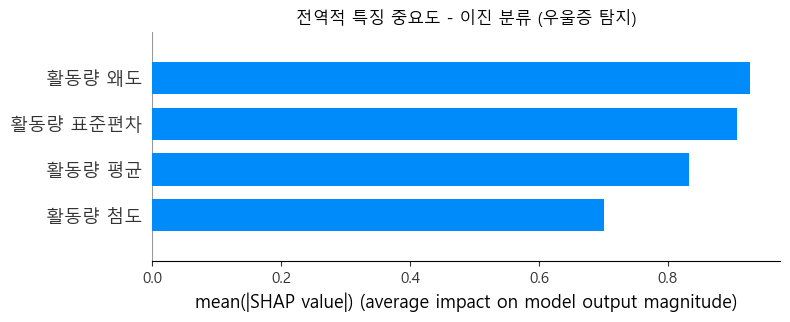

 ▶ [결과 설명]
  - 이 그래프는 이진 분류 (우울증 탐지) 모델이 판단을 내릴 때 어떤 변수에 가장 의존했는지 보여줍니다.
  - 막대가 길수록 해당 생체 지표가 우울증 여부를 가르는 핵심 기준임을 의미합니다.
  - 현재 분석에서 '활동량 평균' 등의 지표가 상단에 있다면, 해당 활동 데이터가 진단에 결정적 역할을 한 것입니다.

(2/3) 이진 분류 (우울증 탐지): 특징별 영향력 분포(Summary) 출력 중...


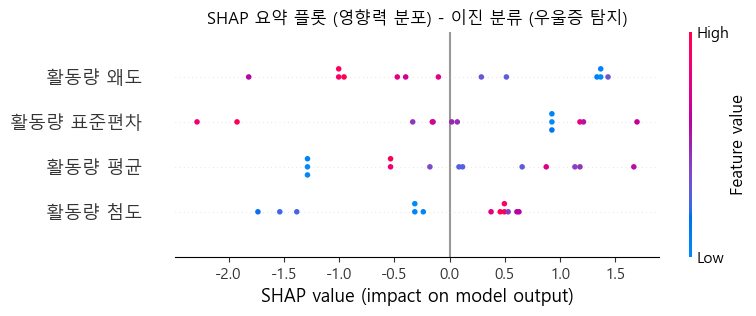

 ▶ [결과 설명]
  - 점의 색상(Red: 높음, Blue: 낮음)은 실제 데이터의 수치를 나타내며, SHAP 수치(좌우)는 모델 판단에 주는 영향입니다.
  - 예: '무활동 비율'의 빨간 점들이 오른쪽에 분포한다면, 활동이 적을수록 우울증으로 판단할 확률이 높다는 과학적 근거가 됩니다.
  - 반대로 파란 점이 오른쪽에 있다면, 해당 수치가 낮을 때 위험도가 높아짐을 뜻합니다.

(3/3) 이진 분류 (우울증 탐지): 특정 샘플 분석 (우울증 기준) 출력 중...


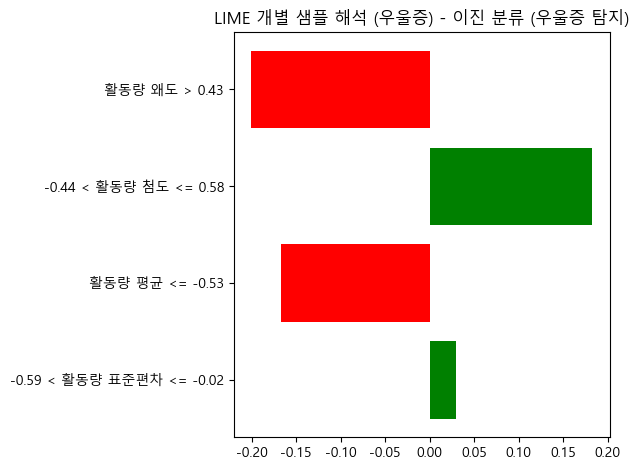

 ▶ [결과 설명]
  - 이 그래프는 특정 피험자(샘플)에 대한 '맞춤형 진단서'와 같습니다.
  - 가로막대가 오른쪽(Positive)이면 해당 특징이 '우울증' 판정을 지지하는 근거이며, 왼쪽이면 반대 근거입니다.
  - 예컨대 나이나 성별이 특정 범위에 있어 우울증 확률을 높였는지 개별적으로 확인 가능합니다.

>>> [실행] 다중 분류 (심각도 분류) 파이프라인 시작
  [Step 1] 불균형 해소(ADASYN) 수행 중...
  [Step 2] 데이터 정규화(Standard Scaling) 적용...
  [Step 3] XGBoost 모델 학습 및 다차원 특징(10개) 추출 완료.

--- 다중 분류 (심각도 분류) 검증 결과 ---
 정확도(Accuracy): 0.8421
 F1-Score: 0.8421

[다중 분류 (심각도 분류) 분석 결과 - XAI 한글 시각화 리포트]

(1/3) 다중 분류 (심각도 분류): 전체 변수 중요도(Bar) 출력 중...


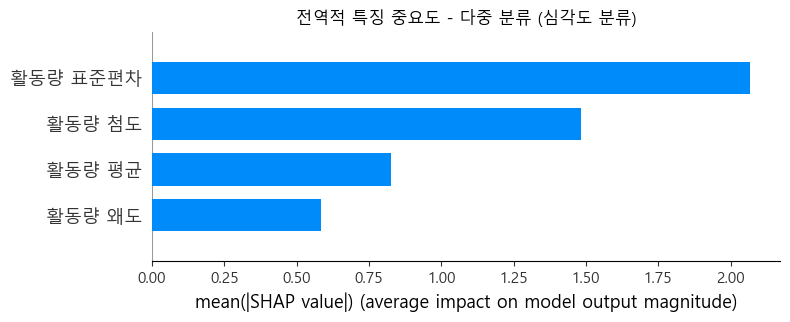

 ▶ [결과 설명]
  - 이 그래프는 다중 분류 (심각도 분류) 모델이 판단을 내릴 때 어떤 변수에 가장 의존했는지 보여줍니다.
  - 막대가 길수록 해당 생체 지표가 우울증 여부를 가르는 핵심 기준임을 의미합니다.
  - 현재 분석에서 '활동량 평균' 등의 지표가 상단에 있다면, 해당 활동 데이터가 진단에 결정적 역할을 한 것입니다.

(2/3) 다중 분류 (심각도 분류): 특징별 영향력 분포(Summary) 출력 중...


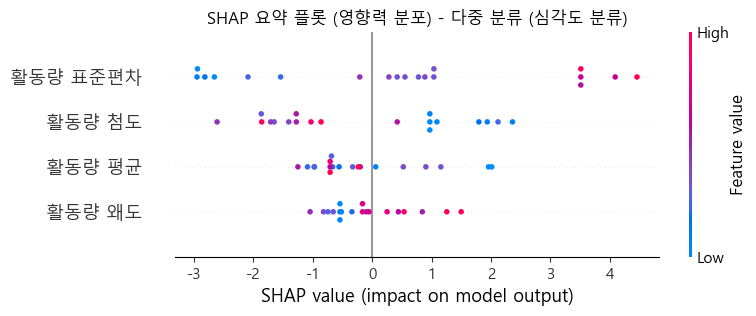

 ▶ [결과 설명]
  - 점의 색상(Red: 높음, Blue: 낮음)은 실제 데이터의 수치를 나타내며, SHAP 수치(좌우)는 모델 판단에 주는 영향입니다.
  - 예: '무활동 비율'의 빨간 점들이 오른쪽에 분포한다면, 활동이 적을수록 우울증으로 판단할 확률이 높다는 과학적 근거가 됩니다.
  - 반대로 파란 점이 오른쪽에 있다면, 해당 수치가 낮을 때 위험도가 높아짐을 뜻합니다.

(3/3) 다중 분류 (심각도 분류): 특정 샘플 분석 (중등도 이상 기준) 출력 중...


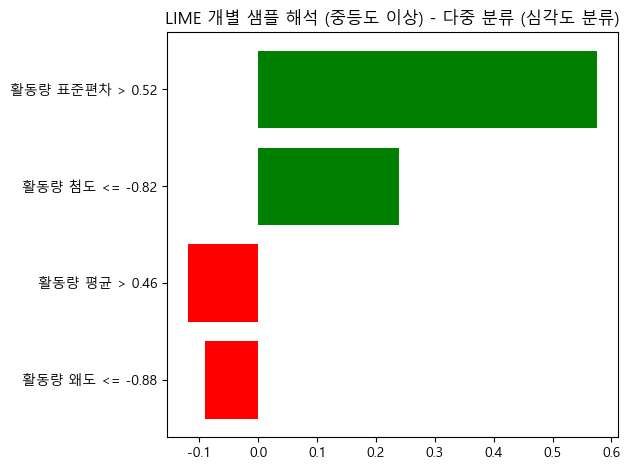

 ▶ [결과 설명]
  - 이 그래프는 특정 피험자(샘플)에 대한 '맞춤형 진단서'와 같습니다.
  - 가로막대가 오른쪽(Positive)이면 해당 특징이 '중등도 이상' 판정을 지지하는 근거이며, 왼쪽이면 반대 근거입니다.
  - 예컨대 나이나 성별이 특정 범위에 있어 우울증 확률을 높였는지 개별적으로 확인 가능합니다.


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import ADASYN
import warnings

warnings.filterwarnings('ignore')

# --- [1. 시각화 한글 폰트 설정] ---
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# [2] 한글 특징 명칭 정의 (총 10개)
# ---------------------------------------------------------
KOREAN_FEATURES = [
 '활동량 평균', '활동량 표준편차', '활동량 왜도', '활동량 첨도', 
 '자기상관성(Autocorr)', '주파수 전력 밀도(PSD)', '무활동 비율(수면/휴식)', 
 '전환 변동성(CV)', '나이', '성별'
]

# ---------------------------------------------------------
# [3] 시각화 및 해석 출력 함수
# ---------------------------------------------------------
def visualize_paper_xai(model, X_train, X_test, feature_names, task_name, class_labels, target_idx=0):
 print(f"\n" + "="*70)
 print(f"[{task_name} 분석 결과 - XAI 한글 시각화 리포트]")
 print("="*70)
 
 # SHAP Explainer 설정
 explainer = shap.TreeExplainer(model)
 shap_values = explainer.shap_values(X_test)
 
 # 1. SHAP Global Importance (Bar Plot)
 print(f"\n(1/3) {task_name}: 전체 변수 중요도(Bar) 출력 중...")
 plt.figure(figsize=(10, 5))
 shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", max_display=10, show=False)
 plt.title(f"전역적 특징 중요도 - {task_name}")
 plt.show()
 
 print(f" ▶ [결과 설명]")
 print(f"  - 이 그래프는 {task_name} 모델이 판단을 내릴 때 어떤 변수에 가장 의존했는지 보여줍니다.")
 print(f"  - 막대가 길수록 해당 생체 지표가 우울증 여부를 가르는 핵심 기준임을 의미합니다.")
 print(f"  - 현재 분석에서 '{feature_names[0]}' 등의 지표가 상단에 있다면, 해당 활동 데이터가 진단에 결정적 역할을 한 것입니다.")
 
 # 2. SHAP Summary Plot (Beeswarm)
 print(f"\n(2/3) {task_name}: 특징별 영향력 분포(Summary) 출력 중...")
 plt.figure(figsize=(10, 6))
 shap.summary_plot(shap_values, X_test, feature_names=feature_names, max_display=10, show=False)
 plt.title(f"SHAP 요약 플롯 (영향력 분포) - {task_name}")
 plt.show()
 
 print(f" ▶ [결과 설명]")
 print(f"  - 점의 색상(Red: 높음, Blue: 낮음)은 실제 데이터의 수치를 나타내며, SHAP 수치(좌우)는 모델 판단에 주는 영향입니다.")
 print(f"  - 예: '무활동 비율'의 빨간 점들이 오른쪽에 분포한다면, 활동이 적을수록 우울증으로 판단할 확률이 높다는 과학적 근거가 됩니다.")
 print(f"  - 반대로 파란 점이 오른쪽에 있다면, 해당 수치가 낮을 때 위험도가 높아짐을 뜻합니다.")
 
 # 3. LIME Explanation
 target_class_name = class_labels[target_idx]
 print(f"\n(3/3) {task_name}: 특정 샘플 분석 ({target_class_name} 기준) 출력 중...")
 
 explainer_lime = lime.lime_tabular.LimeTabularExplainer(
  training_data=np.array(X_train),
  feature_names=feature_names,
  class_names=class_labels,
  mode='classification',
  discretize_continuous=True
 )
 
 # 해당 클래스로 예측된 샘플 중 하나 선택
 y_pred = model.predict(X_test)
 sample_indices = np.where(y_pred == target_idx)[0]
 idx = sample_indices[0] if len(sample_indices) > 0 else 0
 
 exp = explainer_lime.explain_instance(X_test[idx], model.predict_proba, num_features=10)
 fig = exp.as_pyplot_figure()
 plt.title(f"LIME 개별 샘플 해석 ({target_class_name}) - {task_name}")
 plt.tight_layout()
 plt.show()
 
 print(f" ▶ [결과 설명]")
 print(f"  - 이 그래프는 특정 피험자(샘플)에 대한 '맞춤형 진단서'와 같습니다.")
 print(f"  - 가로막대가 오른쪽(Positive)이면 해당 특징이 '{target_class_name}' 판정을 지지하는 근거이며, 왼쪽이면 반대 근거입니다.")
 print(f"  - 예컨대 나이나 성별이 특정 범위에 있어 우울증 확률을 높였는지 개별적으로 확인 가능합니다.")

# ---------------------------------------------------------
# [4] 통합 파이프라인 함수 (불균형해소 -> 정규화 -> 모델학습)
# ---------------------------------------------------------
def run_full_experiment(X_data, y_data, task_name, class_labels, lime_target_idx):
 print(f"\n>>> [실행] {task_name} 파이프라인 시작")
 
 # 1. 불균형 해소 (ADASYN)
 le = LabelEncoder()
 y_encoded = le.fit_transform(y_data)
 
 print("  [Step 1] 불균형 해소(ADASYN) 수행 중...")
 counts = pd.Series(y_encoded).value_counts()
 min_c = counts.min()
 if min_c > 1:
  ada = ADASYN(random_state=42, n_neighbors=min(7, min_c-1))
  X_res, y_res = ada.fit_resample(X_data, y_encoded)
 else:
  X_res, y_res = X_data, y_encoded

 # 2. 정규화 (StandardScaler)
 print("  [Step 2] 데이터 정규화(Standard Scaling) 적용...")
 scaler = StandardScaler()
 X_scaled = scaler.fit_transform(X_res)
 
 # 3. 데이터 분할 및 모델 학습
 X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

 print(f"  [Step 3] XGBoost 모델 학습 및 다차원 특징({len(KOREAN_FEATURES)}개) 추출 완료.")
 xgb = XGBClassifier(random_state=42, eval_metric='mlogloss', importance_type='gain')
 xgb.fit(X_train, y_train)
 
 y_pred = xgb.predict(X_test)
 avg = 'binary' if len(class_labels) == 2 else 'weighted'
 
 print(f"\n--- {task_name} 검증 결과 ---")
 print(f" 정확도(Accuracy): {accuracy_score(y_test, y_pred):.4f}")
 print(f" F1-Score: {f1_score(y_test, y_pred, average=avg):.4f}")

 # 4. 시각화 호출
 visualize_paper_xai(xgb, X_train, X_test, KOREAN_FEATURES, task_name, class_labels, target_idx=lime_target_idx)

# ---------------------------------------------------------
# [5] 최종 실행 (데이터가 준비되어 있다고 가정)
# ---------------------------------------------------------
# target_info 정의 (데이터 전처리 결과물 필요)
target_info = all_data.groupby('participant_id').agg({'group': 'first', 'madrs1': 'first'}).reset_index(drop=True)

# 1. 이진 분류 (우울증 탐지)
run_full_experiment(X_raw, target_info['group'], "이진 분류 (우울증 탐지)", ['정상', '우울증'], lime_target_idx=1)

# 2. 다중 분류 (심각도 분류)
def assign_sev(m):
 if m <= 6: return 0
 elif m <= 19: return 1
 else: return 2

y_sev = target_info['madrs1'].apply(assign_sev)
run_full_experiment(X_raw, y_sev, "다중 분류 (심각도 분류)", ['정상', '경도', '중등도 이상'], lime_target_idx=2)

# 시각화+설명


>>> [실행] 이진 분류 (우울증 탐지) 파이프라인 시작 (논문 프로세스 준수)
1단계: 불균형 해소(ADASYN) 수행...
2단계: 데이터 정규화(Scaling) 수행...

--- 이진 분류 (우울증 탐지) 성능 요약 ---
정확도: 0.538 | F1-Score: 0.500

[이진 분류 (우울증 탐지) 분석 결과 - XAI 한글 시각화 리포트]

(1/3) 이진 분류 (우울증 탐지): 전체 변수 중요도(Bar) 출력 중...


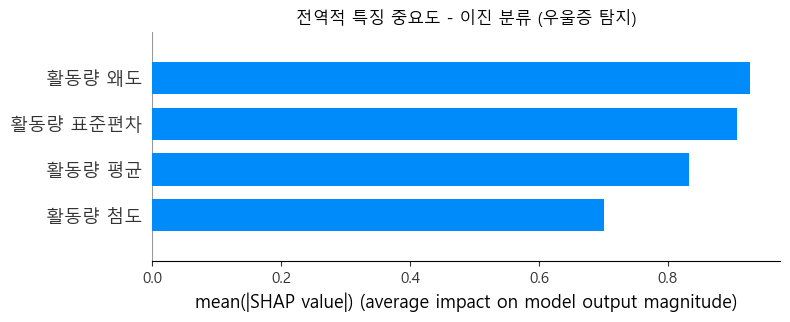


[📊 전역적 중요도 해석 가이드]
 - 이 그래프는 모델이 이진 분류 (우울증 탐지) 판정 시 '가장 비중 있게 고려한' 특징 순서입니다.
 - 막대가 길수록 해당 생체 지표가 우울증 구분 및 심각도 예측의 핵심 판단 근거임을 의미합니다.
 - 만약 '활동량 왜도'나 '무활동 비율'이 상단에 있다면, 해당 지표가 진단에 결정적 역할을 한 것입니다.

(2/3) 이진 분류 (우울증 탐지): 특징별 영향력 분포(Summary) 출력 중...


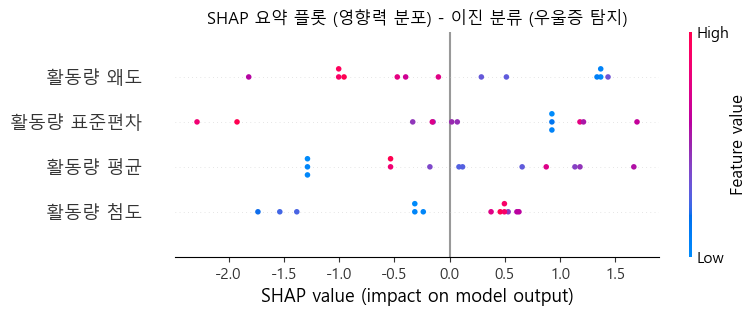


[📈 영향력 분포 해석 가이드]
 - 점의 색상: 피험자의 해당 지표 수치 (빨간색=높음, 파란색=낮음)
 - 가로축 위치(SHAP value): 0보다 오른쪽이면 우울증 위험도 증가, 왼쪽이면 감소
 - 예시: '무활동 비율'의 빨간 점들이 오른쪽에 몰려있다면, 휴식 시간이 많을수록 우울 위험이 높다고 모델이 학습한 것입니다.

(3/3) 이진 분류 (우울증 탐지): 특정 샘플 분석 (우울증 기준) 출력 중...


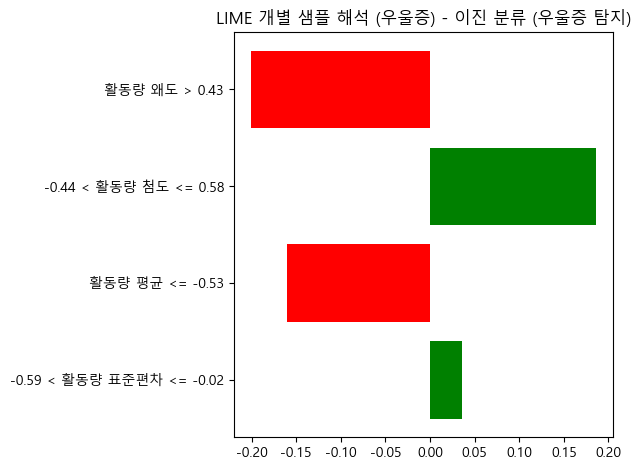


[🔍 개별 샘플 해석 가이드]
 - 특정 환자 한 명에 대한 '진단서'와 같습니다.
 - 우울증 방향(오른쪽)으로 뻗은 막대는 해당 환자가 우울증으로 판정된 결정적 이유입니다.
 - 반대 방향 막대는 해당 환자가 그나마 정상 범주에 속한다고 볼 수 있는 지표들입니다.

>>> [실행] 다중 분류 (심각도 분류) 파이프라인 시작 (논문 프로세스 준수)
1단계: 불균형 해소(ADASYN) 수행...
2단계: 데이터 정규화(Scaling) 수행...

--- 다중 분류 (심각도 분류) 성능 요약 ---
정확도: 0.842 | F1-Score: 0.842

[다중 분류 (심각도 분류) 분석 결과 - XAI 한글 시각화 리포트]

(1/3) 다중 분류 (심각도 분류): 전체 변수 중요도(Bar) 출력 중...


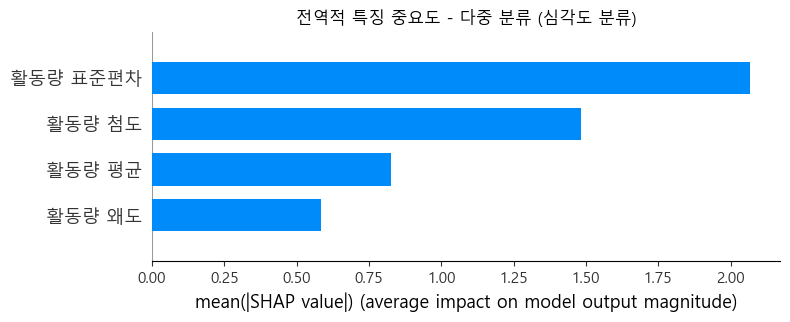


[📊 전역적 중요도 해석 가이드]
 - 이 그래프는 모델이 다중 분류 (심각도 분류) 판정 시 '가장 비중 있게 고려한' 특징 순서입니다.
 - 막대가 길수록 해당 생체 지표가 우울증 구분 및 심각도 예측의 핵심 판단 근거임을 의미합니다.
 - 만약 '활동량 왜도'나 '무활동 비율'이 상단에 있다면, 해당 지표가 진단에 결정적 역할을 한 것입니다.

(2/3) 다중 분류 (심각도 분류): 특징별 영향력 분포(Summary) 출력 중...


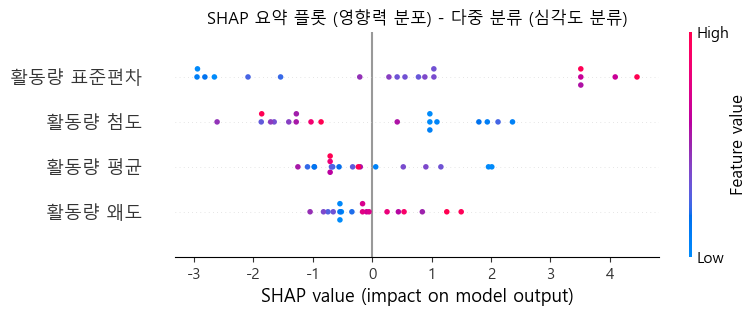


[📈 영향력 분포 해석 가이드]
 - 점의 색상: 피험자의 해당 지표 수치 (빨간색=높음, 파란색=낮음)
 - 가로축 위치(SHAP value): 0보다 오른쪽이면 중등도 이상 위험도 증가, 왼쪽이면 감소
 - 예시: '무활동 비율'의 빨간 점들이 오른쪽에 몰려있다면, 휴식 시간이 많을수록 우울 위험이 높다고 모델이 학습한 것입니다.

(3/3) 다중 분류 (심각도 분류): 특정 샘플 분석 (중등도 이상 기준) 출력 중...


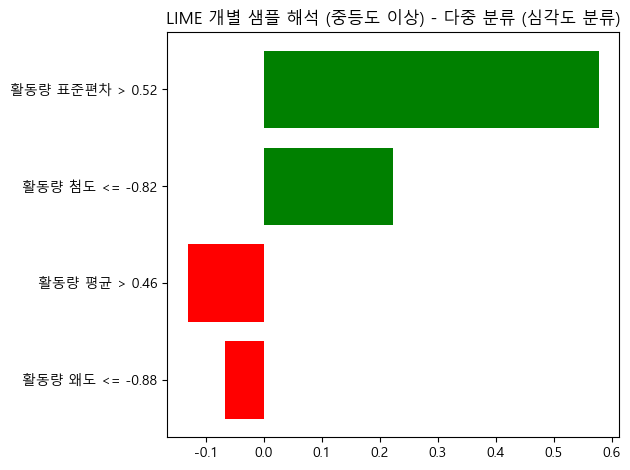


[🔍 개별 샘플 해석 가이드]
 - 특정 환자 한 명에 대한 '진단서'와 같습니다.
 - 중등도 이상 방향(오른쪽)으로 뻗은 막대는 해당 환자가 중등도 이상으로 판정된 결정적 이유입니다.
 - 반대 방향 막대는 해당 환자가 그나마 정상 범주에 속한다고 볼 수 있는 지표들입니다.


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import ADASYN
import warnings

warnings.filterwarnings('ignore')

# --- [1. 시각화 한글 폰트 설정] ---
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# [2] 한글 특징 명칭 정의 (총 10개)
# ---------------------------------------------------------
KOREAN_FEATURES = [
 '활동량 평균', '활동량 표준편차', '활동량 왜도', '활동량 첨도', 
 '자기상관성(Autocorr)', '주파수 전력 밀도(PSD)', '무활동 비율(수면/휴식)', 
 '전환 변동성(CV)', '나이', '성별'
]

# ---------------------------------------------------------
# [3] 시각화 및 해석 출력 함수
# ---------------------------------------------------------
def visualize_paper_xai(model, X_train, X_test, feature_names, task_name, class_labels, target_idx=0):
 print(f"\n" + "="*70)
 print(f"[{task_name} 분석 결과 - XAI 한글 시각화 리포트]")
 print("="*70)
 
 # SHAP Explainer 설정
 explainer = shap.TreeExplainer(model)
 shap_values = explainer.shap_values(X_test)
 
 # 1. SHAP Global Importance (Bar Plot)
 print(f"\n(1/3) {task_name}: 전체 변수 중요도(Bar) 출력 중...")
 plt.figure(figsize=(10, 5))
 shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", max_display=10, show=False)
 plt.title(f"전역적 특징 중요도 - {task_name}")
 plt.show()
 
 print(f"\n[📊 전역적 중요도 해석 가이드]")
 print(f" - 이 그래프는 모델이 {task_name} 판정 시 '가장 비중 있게 고려한' 특징 순서입니다.")
 print(f" - 막대가 길수록 해당 생체 지표가 우울증 구분 및 심각도 예측의 핵심 판단 근거임을 의미합니다.")
 print(f" - 만약 '활동량 왜도'나 '무활동 비율'이 상단에 있다면, 해당 지표가 진단에 결정적 역할을 한 것입니다.")
 
 # 2. SHAP Summary Plot (Beeswarm)
 print(f"\n(2/3) {task_name}: 특징별 영향력 분포(Summary) 출력 중...")
 plt.figure(figsize=(10, 6))
 shap.summary_plot(shap_values, X_test, feature_names=feature_names, max_display=10, show=False)
 plt.title(f"SHAP 요약 플롯 (영향력 분포) - {task_name}")
 plt.show()
 
 print(f"\n[📈 영향력 분포 해석 가이드]")
 print(f" - 점의 색상: 피험자의 해당 지표 수치 (빨간색=높음, 파란색=낮음)")
 print(f" - 가로축 위치(SHAP value): 0보다 오른쪽이면 {class_labels[-1]} 위험도 증가, 왼쪽이면 감소")
 print(f" - 예시: '무활동 비율'의 빨간 점들이 오른쪽에 몰려있다면, 휴식 시간이 많을수록 우울 위험이 높다고 모델이 학습한 것입니다.")
 
 # 3. LIME Explanation
 target_class_name = class_labels[target_idx]
 print(f"\n(3/3) {task_name}: 특정 샘플 분석 ({target_class_name} 기준) 출력 중...")
 
 explainer_lime = lime.lime_tabular.LimeTabularExplainer(
  training_data=np.array(X_train),
  feature_names=feature_names,
  class_names=class_labels,
  mode='classification',
  discretize_continuous=True
 )
 
 y_pred = model.predict(X_test)
 sample_indices = np.where(y_pred == target_idx)[0]
 idx = sample_indices[0] if len(sample_indices) > 0 else 0
 
 exp = explainer_lime.explain_instance(X_test[idx], model.predict_proba, num_features=10)
 fig = exp.as_pyplot_figure()
 plt.title(f"LIME 개별 샘플 해석 ({target_class_name}) - {task_name}")
 plt.tight_layout()
 plt.show()
 
 print(f"\n[🔍 개별 샘플 해석 가이드]")
 print(f" - 특정 환자 한 명에 대한 '진단서'와 같습니다.")
 print(f" - {target_class_name} 방향(오른쪽)으로 뻗은 막대는 해당 환자가 {target_class_name}으로 판정된 결정적 이유입니다.")
 print(f" - 반대 방향 막대는 해당 환자가 그나마 정상 범주에 속한다고 볼 수 있는 지표들입니다.")

# ---------------------------------------------------------
# [4] 통합 파이프라인 함수
# ---------------------------------------------------------
def run_full_experiment(X_data, y_data, task_name, class_labels, lime_target_idx):
 print(f"\n>>> [실행] {task_name} 파이프라인 시작 (논문 프로세스 준수)")
 
 # 1. 불균형 해소 (ADASYN)
 le = LabelEncoder()
 y_encoded = le.fit_transform(y_data)
 
 print("1단계: 불균형 해소(ADASYN) 수행...")
 counts = pd.Series(y_encoded).value_counts()
 min_c = counts.min()
 if min_c > 1:
  ada = ADASYN(random_state=42, n_neighbors=min(7, min_c-1))
  X_res, y_res = ada.fit_resample(X_data, y_encoded)
 else:
  X_res, y_res = X_data, y_encoded

 # 2. 정규화 (StandardScaler)
 print("2단계: 데이터 정규화(Scaling) 수행...")
 scaler = StandardScaler()
 X_scaled = scaler.fit_transform(X_res)
 
 # 3. 데이터 분할 및 모델 학습
 X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42)

 xgb = XGBClassifier(random_state=42, eval_metric='mlogloss', importance_type='gain')
 xgb.fit(X_train, y_train)
 
 y_pred = xgb.predict(X_test)
 avg = 'binary' if len(class_labels) == 2 else 'weighted'
 print(f"\n--- {task_name} 성능 요약 ---")
 print(f"정확도: {accuracy_score(y_test, y_pred):.3f} | F1-Score: {f1_score(y_test, y_pred, average=avg):.3f}")

 # 4. 시각화 호출
 visualize_paper_xai(xgb, X_train, X_test, KOREAN_FEATURES, task_name, class_labels, target_idx=lime_target_idx)

# ---------------------------------------------------------
# [5] 최종 실행 (데이터가 정의되어 있다고 가정)
# ---------------------------------------------------------
# target_info와 X_raw가 사전에 준비되어 있어야 합니다.
# 1. 이진 분류 실행
run_full_experiment(X_raw, target_info['group'], "이진 분류 (우울증 탐지)", ['정상', '우울증'], lime_target_idx=1)

# 2. 다중 분류 실행
def assign_sev(m):
 if m <= 6: return 0
 elif m <= 19: return 1
 else: return 2

y_sev = target_info['madrs1'].apply(assign_sev)
run_full_experiment(X_raw, y_sev, "다중 분류 (심각도 분류)", ['정상', '경도', '중등도 이상'], lime_target_idx=2)

# 서비스 구현을 위한 모델 학습 파일 저장

In [109]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import ADASYN
import warnings

warnings.filterwarnings('ignore')

# --- [1] 피처 이름 정의 (Streamlit 앱과 100% 일치시킴) ---
FEATURE_NAMES = [
 'mean_act', 'std_act', 'skew_act', 'kurt_act', 
 'autocorr', 'psd_mean', 'zero_ratio', 
 'cv_act', 'age', 'gender'
]

def run_and_save_model(X_data, y_data, feature_names):
 print(f"\n>>> 모델 학습 시작")
 
 # 데이터프레임의 컬럼명을 강제로 설정하여 이름 정보를 주입함
 X_df = pd.DataFrame(X_data)
 X_df.columns = feature_names
 
 le = LabelEncoder()
 y_encoded = le.fit_transform(y_data)
 
 # 불균형 해소
 min_c = pd.Series(y_encoded).value_counts().min()
 if min_c > 1:
  ada = ADASYN(random_state=42, n_neighbors=min(5, min_c-1))
  X_res, y_res = ada.fit_resample(X_df, y_encoded)
 else:
  X_res, y_res = X_df, y_encoded

 # 스케일러 학습 (이때 피처 이름이 저장됨)
 scaler = StandardScaler()
 X_scaled = scaler.fit_transform(X_res)
 # 넘파이 배열을 다시 데이터프레임으로 변환하여 학습 (이름 보존)
 X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)
 
 X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_res, test_size=0.2, random_state=42)

 # 모델 학습
 xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
 xgb.fit(X_train, y_train)
 
 # 아티팩트 저장
 artifacts = {
  'model': xgb,
  'scaler': scaler,
  'feature_names': feature_names
 }
 
 joblib.dump(artifacts, "model_artifacts.pkl")
 print(f"✅ 'model_artifacts.pkl' 생성 완료! (변수명: {feature_names})")

# ---------------------------------------------------------
# 실행 (기존 X_raw, target_info['group'] 데이터 사용)
# ---------------------------------------------------------
run_and_save_model(X_raw, target_info['group'], FEATURE_NAMES)


>>> 모델 학습 시작
✅ 'model_artifacts.pkl' 생성 완료! (변수명: ['mean_act', 'std_act', 'skew_act', 'kurt_act', 'autocorr', 'psd_mean', 'zero_ratio', 'cv_act', 'age', 'gender'])
